In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd

# DATA_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Experiment/data'
# VAL_TO_IDX_DATA_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Server/data'

# MODEL_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Experiment/model'

In [2]:
problem_df = pd.read_csv('clean_problem.csv')

problem_df.columns.values[1] = 'problem_id'
problem_df.columns.values[10] = 'problem_tags'

problem_df['problem_id'] = problem_df['problem_id'].astype(str)

In [5]:
problem_df.head()

,Unnamed: 0.1,problem_id,titleKo,titles,isSolvable,acceptedUserCount,level,givesNoRating,averageTries,official,problem_tags,Unnamed: 0,0
0,0,1000,A+B,"[{'language': 'en', 'languageDisplayName': 'en...",True,248747,1,False,2.4906,True,"implementation,arithmetic,math,",0,1000
1,1,1001,A-B,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,211935,1,False,1.4210,True,"implementation,arithmetic,math,",1,1001
2,2,1002,터렛,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,33220,8,False,4.4786,True,"case_work,geometry,math,",2,1002
3,3,1003,피보나치 함수,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,45403,8,False,3.0812,True,"dp,",3,1003
4,4,1004,어린 왕자,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,13610,8,False,2.1913,True,"geometry,math,",4,1004


In [6]:
# # problem_association_seq 제작

# import re

# problem_association_seq_list = set()
# problem_id_list = problem_df['problem_id'].tolist()

# problem_association_list = problem_df['problem_association'].tolist()
# title_list = problem_df['title'].tolist()
# for title, problem_association in zip(title_list, problem_association_list):
#     problem_association = eval(problem_association)
#     if problem_association:
#         problem_association += [title]
#         problem_association = sorted(list(set(problem_id_list) & set(re.findall(r'([0-9]+?)번', '#'.join(problem_association)))))
#         problem_association_seq_list.add(tuple(problem_association))

# problem_association_seq_list = list(map(list, problem_association_seq_list))

# len(problem_association_seq_list)

KeyError: ignored

In [9]:
# level로 seq 제작

problem_level_seq_list = []

group_df = problem_df.groupby('level')

for level, df in group_df:
    problem_level_seq_list.append(df['problem_id'].tolist())

print(len(problem_level_seq_list))
for i in problem_level_seq_list:
  print(i)

30
['1000', '1001', '1008', '1271', '1330', '2338', '2420', '2438', '2475', '2557', '2558', '2738', '2739', '2741', '2743', '2744', '2753', '2754', '3003', '4101', '4999', '5337', '5338', '5339', '5522', '5597', '7287', '8393', '9086', '9498', '9653', '9654', '10171', '10172', '10430', '10699', '10718', '10757', '10807', '10869', '10871', '10872', '10926', '10950', '10951', '10952', '10998', '11021', '11022', '11382', '11654', '11718', '11942', '13277', '14581', '14645', '14652', '14681', '14928', '15680', '15727', '15733', '15740', '15962', '15964', '16170', '16394', '16430', '17256', '18108', '20492', '21598', '24262', '24900']
['1264', '2083', '2439', '2440', '2480', '2530', '2742', '2752', '2845', '4299', '4470', '5524', '5532', '5543', '5554', '5575', '5596', '5717', '10039', '10101', '10156', '10768', '10797', '10808', '11282', '11283', '11365', '11720', '11943', '11945', '11948', '13118', '13136', '13752', '13866', '14470', '14489', '14924', '14935', '15439', '15552', '15700', '

In [16]:
# arr = '임정우,백지원,노명은,한상진,'
# arr = [arr]
# tags = eval(arr)
# tags
arr = ''
arr = arr.split(',')
arr.pop()
print(arr)

[]


In [22]:
# tag로 seq 제작

problem_tag_seq_list = []

tag_list = []

def get_preprocessing_tags(tags):
    global tag_list
    # tags = eval(tags)
    if type(tags) != 'float':
      tags = str(tags).split(',')
      tags.pop()
      tags = [tag for tag in tags]
      tag_list += tags
    return tags

problem_df['preprocessing_tags'] = problem_df['problem_tags'].apply(lambda x : get_preprocessing_tags(x))
tag_list = list(set(tag_list))
problem_num_list = problem_df['problem_id'].tolist()

tag_df = pd.DataFrame(data = np.zeros((len(problem_num_list), len(tag_list))), columns = tag_list, index = problem_num_list)

for df in problem_df.iloc:
    tag_df.loc[df['problem_id'], df['preprocessing_tags']] = 1

for tag in tag_list:
    problem_tag_seq = tag_df[tag_df[tag] == 1].index.tolist()
    problem_tag_seq_list.append(problem_tag_seq)

len(problem_tag_seq_list)

187

In [28]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.callbacks import CallbackAny2Vec
import datetime

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 1
        self.loss_to_be_subed = 0
        self.loss_now = 987654321

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed

        self.loss_to_be_subed = loss
        print(loss_now, self.loss_now)
        if loss_now < self.loss_now:
            self.loss_now = loss_now
            # model.save(os.path.join(MODEL_PATH, 'clean-Word2Vec-CBOW-problem_association_seq-problem_level_seq-problem_tag_seq-vs128.model'))
            print(f'Loss after epoch {self.epoch}: {loss_now}')
            # print('Model 저장')
        self.epoch += 1

start = datetime.datetime.now()

sentences = problem_level_seq_list + problem_tag_seq_list

model = Word2Vec(
                sentences = sentences,
                seed = 22,
                epochs = 300,
                min_count = 1,
                vector_size = 128,
                sg = 0,
                negative = 10,
                window = 987654321,
                compute_loss = True,
                callbacks=[callback()],
                 )

print("Time passed: " + str(datetime.datetime.now() - start))

61325.2265625 987654321
Loss after epoch 1: 61325.2265625
36776.6484375 61325.2265625
Loss after epoch 2: 36776.6484375
35374.53125 36776.6484375
Loss after epoch 3: 35374.53125
34903.546875 35374.53125
Loss after epoch 4: 34903.546875
34486.75 34903.546875
Loss after epoch 5: 34486.75
34182.09375 34486.75
Loss after epoch 6: 34182.09375
32977.078125 34182.09375
Loss after epoch 7: 32977.078125
31998.6875 32977.078125
Loss after epoch 8: 31998.6875
30925.9375 31998.6875
Loss after epoch 9: 30925.9375
29544.21875 30925.9375
Loss after epoch 10: 29544.21875
28624.28125 29544.21875
Loss after epoch 11: 28624.28125
27777.21875 28624.28125
Loss after epoch 12: 27777.21875
26943.1875 27777.21875
Loss after epoch 13: 26943.1875
26145.21875 26943.1875
Loss after epoch 14: 26145.21875
25256.125 26145.21875
Loss after epoch 15: 25256.125
24420.34375 25256.125
Loss after epoch 16: 24420.34375
23627.96875 24420.34375
Loss after epoch 17: 23627.96875
23091.0625 23627.96875
Loss after epoch 18: 2309

In [65]:
# from gensim.models import Word2Vec

# with open(os.path.join(VAL_TO_IDX_DATA_PATH, 'clean_problem_id_to_idx.json'), 'r', encoding = 'utf-8') as f:
#     problem_id2idx = json.load(f)

# with open(os.path.join(VAL_TO_IDX_DATA_PATH, 'clean_idx_to_problem_id.json'), 'r', encoding = 'utf-8') as f:
#     idx2problem_id = json.load(f)

ids = problem_df["problem_id"].to_list()
vectors = []
for id in ids:
  vectors.append(model.wv[id])
vectors = np.array(vectors)

In [91]:
vectors

array([[ 2.1190255 ,  0.6971971 ,  0.95942944, ...,  1.9225997 ,
        -1.0943136 , -1.4537959 ],
       [ 2.1967509 ,  0.804097  ,  0.97800463, ...,  1.8819999 ,
        -1.0026585 , -1.4242516 ],
       [-1.4515874 , -0.781403  , -0.19891587, ...,  1.203208  ,
         0.72552127, -1.0386336 ],
       ...,
       [ 1.6559517 ,  0.6654069 ,  0.23953348, ..., -0.63143164,
         0.645006  , -0.69031906],
       [ 0.99763894, -2.3341453 ,  3.185706  , ..., -0.02128169,
        -0.8397076 , -2.6668544 ],
       [ 1.9197587 ,  0.14984629, -0.09637666, ..., -0.254964  ,
         0.64547396, -0.69723105]], dtype=float32)

In [ ]:
# with open(os.path.join(MODEL_PATH, 'clean-Word2Vec-CBOW-problem_association_seq-problem_level_seq-problem_tag_seq-vs128-vector.pickle'), 'wb') as file:
#     pickle.dump(vectors, file, protocol = 4)

In [66]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state = 0)
tsne_vectors = tsne.fit_transform(vectors)

In [69]:
vectors.shape

(7144, 128)

In [70]:
tsne_vectors

array([[ 49.489418 ,  40.579876 ],
       [ 49.535618 ,  40.592674 ],
       [  3.5942807,  57.53357  ],
       ...,
       [-34.296066 ,  60.16665  ],
       [ -8.859338 , -15.557964 ],
       [-32.67074  ,  60.083153 ]], dtype=float32)

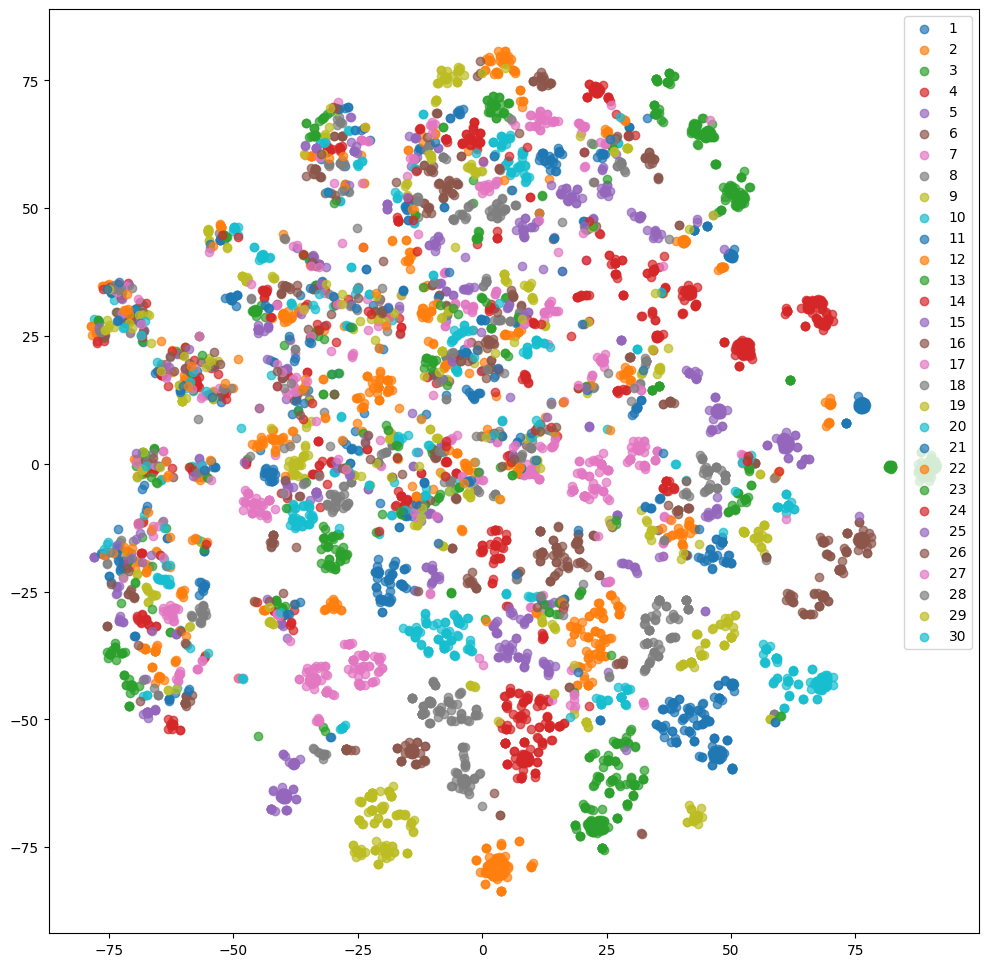

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))
problem_df.rename(columns={"Unnamed: 0.1":"id_to_idx"},inplace=True)
for level in sorted(problem_df['level'].unique()):
    idx = problem_df[problem_df['level'] == level]['id_to_idx'].tolist()
    idx = list(map(int, idx))
    #idx = clean_idx(idx)
    plt.scatter(x = tsne_vectors[idx, 0], y = tsne_vectors[idx, 1], alpha = 0.7, label = f'{level}')

plt.legend()
plt.show()

In [87]:
tsne_vectors_df = pd.DataFrame(data = tsne_vectors, columns = ['x', 'y'])

In [88]:
idx = tsne_vectors_df[((-60 <= tsne_vectors_df['x']) & (tsne_vectors_df['x'] <= -35)) & ((-100 <= tsne_vectors_df['y']) & (tsne_vectors_df['y'] <= -50))].index.tolist()

In [56]:
tsne_vectors

array([[-144.26247],
       [-144.26694],
       [-144.25134],
       ...,
       [ 147.86232],
       [ 147.90463],
       [ 147.91061]], dtype=float32)

In [90]:
problem_df

,id_to_idx,problem_id,titleKo,titles,isSolvable,acceptedUserCount,level,givesNoRating,averageTries,official,problem_tags,Unnamed: 0,0,preprocessing_tags
0,0,1000,A+B,"[{'language': 'en', 'languageDisplayName': 'en...",True,248747,1,False,2.4906,True,"implementation,arithmetic,math,",0,1000,"[implementation, arithmetic, math]"
1,1,1001,A-B,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,211935,1,False,1.4210,True,"implementation,arithmetic,math,",1,1001,"[implementation, arithmetic, math]"
2,2,1002,터렛,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,33220,8,False,4.4786,True,"case_work,geometry,math,",2,1002,"[case_work, geometry, math]"
3,3,1003,피보나치 함수,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,45403,8,False,3.0812,True,"dp,",3,1003,[dp]
4,4,1004,어린 왕자,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,13610,8,False,2.1913,True,"geometry,math,",4,1004,"[geometry, math]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7139,7139,24954,물약 구매,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,215,10,False,1.8140,True,"bruteforcing,implementation,",7625,24954,"[bruteforcing, implementation]"
7140,7140,24955,숫자 이어 붙이기,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,129,12,False,3.0853,True,"bfs,dfs,graphs,graph_traversal,lca,math,trees,",7626,24955,"[bfs, dfs, graphs, graph_traversal, lca, math,..."
7141,7141,24956,나는 정말 휘파람을 못 불어,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,181,12,False,3.5967,True,"combinatorics,dp,math,",7627,24956,"[combinatorics, dp, math]"
7142,7142,24968,트리의 간선 바꾸기,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,5,21,False,2.2000,True,"euler_tour_technique,lca,prefix_sum,trees,",7628,24968,"[euler_tour_technique, lca, prefix_sum, trees]"
